# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cpu


## 3. CIFAR10 Data Normalization and Augmentation

In [3]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


문제) 학습 데이터(training data)의 색상별 평균과 표준 편차를 구하자.

In [4]:
print(train_data)
print((train_data.data/255).mean(axis=(0,1,2))) 
print((train_data.data/255).std(axis=(0,1,2))) 
print((train_data.data/255).mean(axis=(0,1,2)).mean()) # 조교님 이것하고 밑에 있는 줄은 코드에는 영향을 주지 않고 혼자 실험해본 값입니다.
print((train_data.data/255).std(axis=(0,1,2)).mean())  # 결과 출력은 했으나, 이전에 정규화할때 값을 바꾸기 위한 기준으로test만 해본 값입니다.

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
0.4733630004850915
0.2507017340637674


문제) 위 내용을 반영하여 데이터를 Normalize 하고 랜덤하게 좌우반전 및 흑백 사진으로 바꾸자.

In [5]:
transform = transforms.Compose(
    [
        
        transforms.ToTensor(),
        
        transforms.Normalize((train_data.data/255).mean(axis=(0,1,2)) ,(train_data.data/255).std(axis=(0,1,2))),
        #transforms.Normalize((0.5,) ,(0.5,)),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomHorizontalFlip(p = 0.5),
       
    ])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


완성된 dataset.CIFAR10 객체를 train_loader에 넣는다.

In [6]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)    

아래의 코드를 여러번 돌려, 실제로 좌우반전 및 흑백사진으로 변하는지 확인하자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


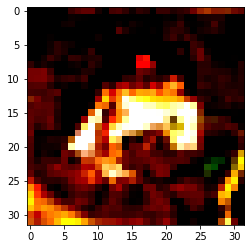

In [7]:
for (X_train, y_train) in train_loader:
    plt.imshow(X_train[0].permute(1,2,0).numpy())
    plt.show()
    break

## 4. torch.nn을 이용하여 모델-1 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Batch Normalization 을 사용할 것

In [8]:
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1,self).__init__()
        self.fc1 = nn.Linear(3072,100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(10)
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        return x

## 5. torch.nn을 이용하여 모델-2 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Dropout을 확률을 50%로 사용할 것 - BN는 사용하지 말것!

In [9]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2,self).__init__()
        self.fc1 = nn.Linear(3072,100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.dropout(x)
        return x

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [10]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image =image.view(-1,3*32*32)

        # Forward propagration 계산하기.
        outputs = network.forward(image)
        
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        cls_loss = nn.CrossEntropyLoss()
        loss = cls_loss(outputs,label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs.data, 1)
        train_correct += pred.eq(label).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [11]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(-1, 3*32*32)

            # Forward propagration 계산하기.
            outputs = network.forward(image)

            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            cls_loss = nn.CrossEntropyLoss()
            loss = cls_loss(outputs,label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.argmax(outputs.data, 1)
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

1. SGD Optimizer를 사용하고

2. Regularizer 를 사용하여 (weight_decay = 0.01로 사용할 것)

학습시키기

In [12]:
def training(network, learning_rate = 0.01):
    
#     learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.01)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [13]:
network = Model_1()
rlt_const = training(network)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.458683
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.059338
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.916237
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.957375

Training set: Accuracy: 16949/50000 (34%)
Test set: Accuracy: 3865/10000 (39%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.916623
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.898924
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.873938
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.921195

Training set: Accuracy: 19269/50000 (39%)
Test set: Accuracy: 4030/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.863790
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.990405
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.856455
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.873920

Training set: Accuracy: 19943/50000 (40%)
Test set: Accuracy: 4259/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.859009
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.802953
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.869148
Train Epoch: 3 [48000/50000

In [14]:
network2 = Model_2()
rlt_const2 = training(network2, 0.05)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.288342
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.236718
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.088162
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.502969

Training set: Accuracy: 13399/50000 (27%)
Test set: Accuracy: 3210/10000 (32%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.941092
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.015697
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.136747
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.287411

Training set: Accuracy: 14471/50000 (29%)
Test set: Accuracy: 3164/10000 (32%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.114746
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.179175
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.056090
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.430407

Training set: Accuracy: 14400/50000 (29%)
Test set: Accuracy: 3446/10000 (34%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.902856
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.074190
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.197521
Train Epoch: 3 [48000/50000

# 8.학습 결과 보기 
## loss와 Accuracy 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

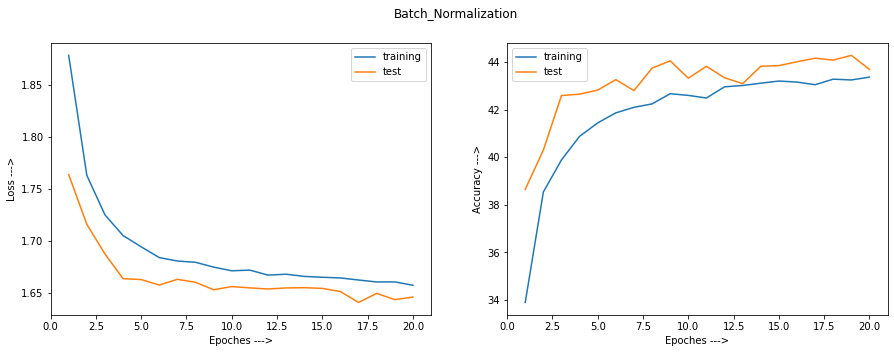

In [16]:
show_rlt(rlt_const, 'Batch_Normalization')

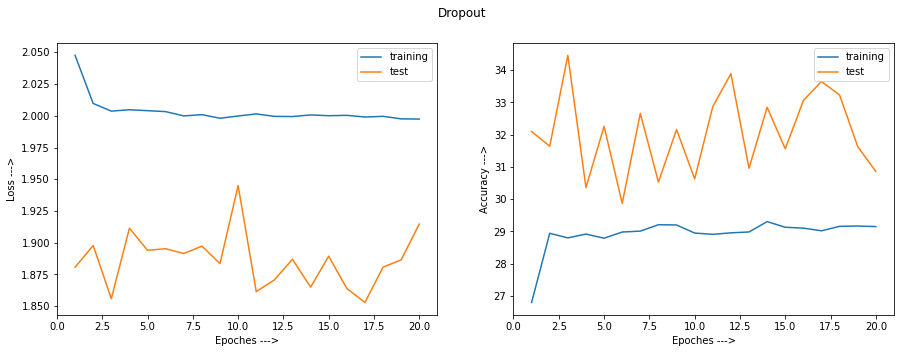

In [17]:
show_rlt(rlt_const2, 'Dropout')

# 9. Hyperparameter 찾기

위 Dropout 모델의 최적의 learning rate를 찾으세요.

스스로 계획을 짜고 어떤 lr 이 가장 나은 성능을 내었는지 분석하세요.

* lr을 극단적으로 줄였을 경우 *

In [18]:
network = Model_1()
rlt_const = training(network,0.005)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.400817
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.058644
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.014991
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.954503

Training set: Accuracy: 16569/50000 (33%)
Test set: Accuracy: 3789/10000 (38%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.969646
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.958043
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.893158
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.867485

Training set: Accuracy: 18781/50000 (38%)
Test set: Accuracy: 3954/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.867625
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.955484
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.854158
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.857753

Training set: Accuracy: 19746/50000 (39%)
Test set: Accuracy: 4139/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.933576
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.975980
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.788281
Train Epoch: 3 [48000/50000

In [19]:
network2 = Model_2()
rlt_const2 = training(network2, 0.005)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.350243
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.206953
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.132946
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.070418

Training set: Accuracy: 14636/50000 (29%)
Test set: Accuracy: 3596/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.854064
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.035187
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.913342
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.031290

Training set: Accuracy: 16900/50000 (34%)
Test set: Accuracy: 3805/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.723996
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.090141
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.067223
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.082184

Training set: Accuracy: 17610/50000 (35%)
Test set: Accuracy: 4006/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.901152
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.734029
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.122960
Train Epoch: 3 [48000/50000

In [20]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

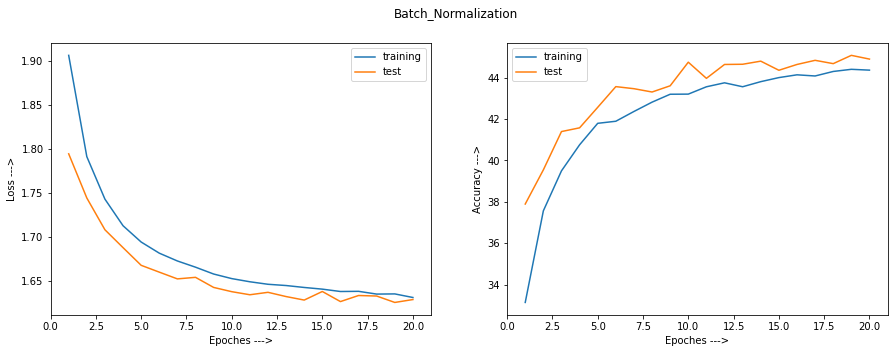

In [21]:
show_rlt(rlt_const, 'Batch_Normalization')

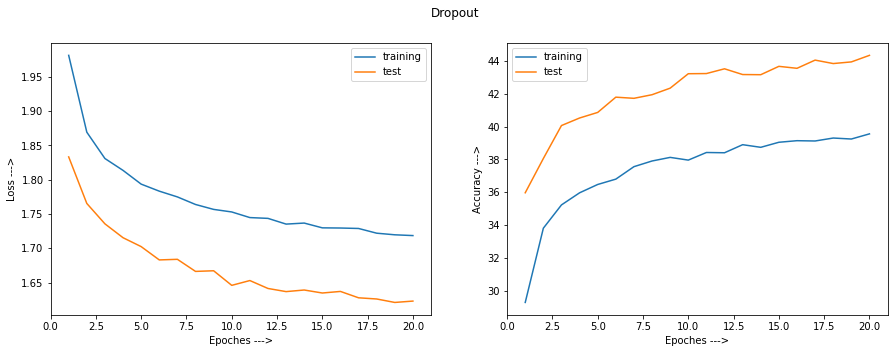

In [22]:
show_rlt(rlt_const2, 'Dropout')

* 여기서 조금씩 변경 이 경우는 증가 *

In [23]:
network = Model_1()
rlt_const = training(network,0.006)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.297620
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.104253
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.925502
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.081867

Training set: Accuracy: 16786/50000 (34%)
Test set: Accuracy: 3840/10000 (38%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.910801
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.029970
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.873839
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.889347

Training set: Accuracy: 18936/50000 (38%)
Test set: Accuracy: 4022/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.932623
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.837068
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.881482
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.900139

Training set: Accuracy: 19756/50000 (40%)
Test set: Accuracy: 4137/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.873287
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.729741
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.828449
Train Epoch: 3 [48000/50000

In [24]:
network2 = Model_2()
rlt_const2 = training(network2, 0.006)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.335602
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.243781
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.008728
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.001785

Training set: Accuracy: 14800/50000 (30%)
Test set: Accuracy: 3610/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.978851
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.092731
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.884905
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.055921

Training set: Accuracy: 16958/50000 (34%)
Test set: Accuracy: 3880/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.931017
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.061796
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.740390
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.156594

Training set: Accuracy: 17456/50000 (35%)
Test set: Accuracy: 3963/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.780769
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.861997
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.807475
Train Epoch: 3 [48000/50000

In [25]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

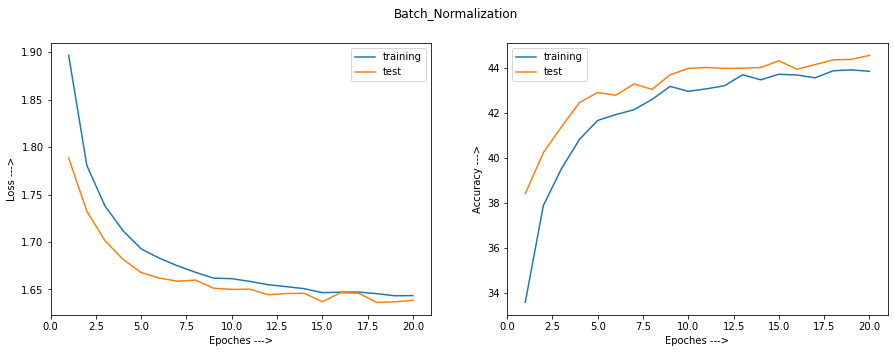

In [26]:
show_rlt(rlt_const, 'Batch_Normalization')

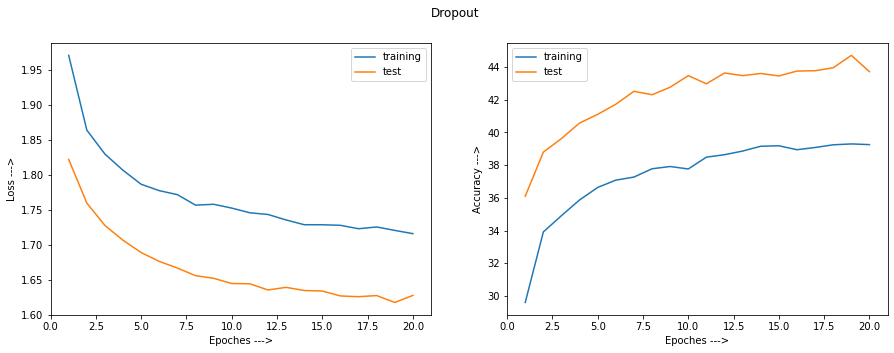

In [27]:
show_rlt(rlt_const2, 'Dropout')

* 조금 감소 *

In [28]:
network = Model_1()
rlt_const = training(network,0.004)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.460661
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.076255
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.999453
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.014532

Training set: Accuracy: 16399/50000 (33%)
Test set: Accuracy: 3763/10000 (38%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.010850
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.909778
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.953293
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.987987

Training set: Accuracy: 18692/50000 (37%)
Test set: Accuracy: 3961/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.800984
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.927538
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.932319
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.888672

Training set: Accuracy: 19501/50000 (39%)
Test set: Accuracy: 4103/10000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.865559
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.822102
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.939789
Train Epoch: 3 [48000/50000

In [29]:
network2 = Model_2()
rlt_const2 = training(network2, 0.004)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.390220
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.194743
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.918122
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.902360

Training set: Accuracy: 14534/50000 (29%)
Test set: Accuracy: 3545/10000 (35%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.052590
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.915828
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.009562
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.906335

Training set: Accuracy: 16668/50000 (33%)
Test set: Accuracy: 3771/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.833770
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.854557
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.924748
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.952386

Training set: Accuracy: 17380/50000 (35%)
Test set: Accuracy: 3952/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.901473
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.907711
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.877639
Train Epoch: 3 [48000/50000

In [30]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

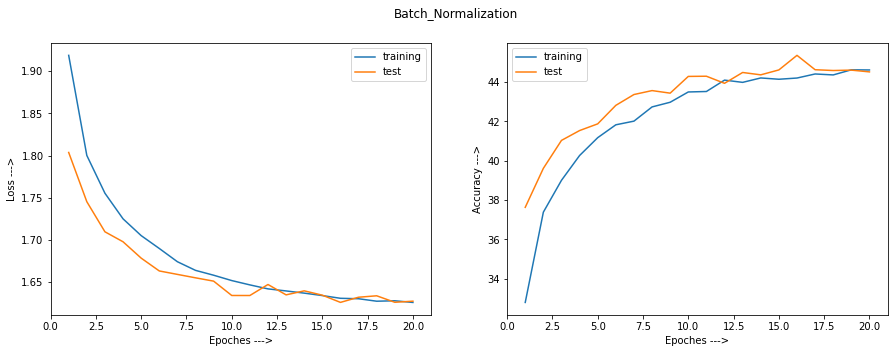

In [31]:
show_rlt(rlt_const, 'Batch_Normalization')

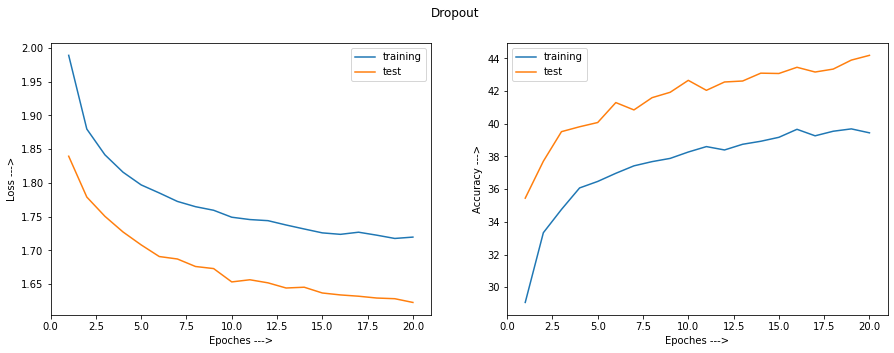

In [32]:
show_rlt(rlt_const2, 'Dropout')

In [33]:
network = Model_1()
rlt_const = training(network,0.05)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.407452
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.085556
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.926864
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.948296

Training set: Accuracy: 17291/50000 (35%)
Test set: Accuracy: 3957/10000 (40%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.003824
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.826604
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.934929
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.865890

Training set: Accuracy: 18942/50000 (38%)
Test set: Accuracy: 3961/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.878902
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.876035
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.962717
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.943066

Training set: Accuracy: 19198/50000 (38%)
Test set: Accuracy: 4023/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.946722
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.876518
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.917103
Train Epoch: 3 [48000/50000

In [34]:
network2 = Model_2()
rlt_const2 = training(network2, 0.05)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.296073
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.345285
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.202166
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.427640

Training set: Accuracy: 13543/50000 (27%)
Test set: Accuracy: 3275/10000 (33%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.039025
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.135586
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.959962
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.035259

Training set: Accuracy: 14309/50000 (29%)
Test set: Accuracy: 3055/10000 (31%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.102658
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.742692
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.074373
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.330909

Training set: Accuracy: 14396/50000 (29%)
Test set: Accuracy: 3310/10000 (33%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.116601
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.441094
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.037311
Train Epoch: 3 [48000/50000

In [35]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

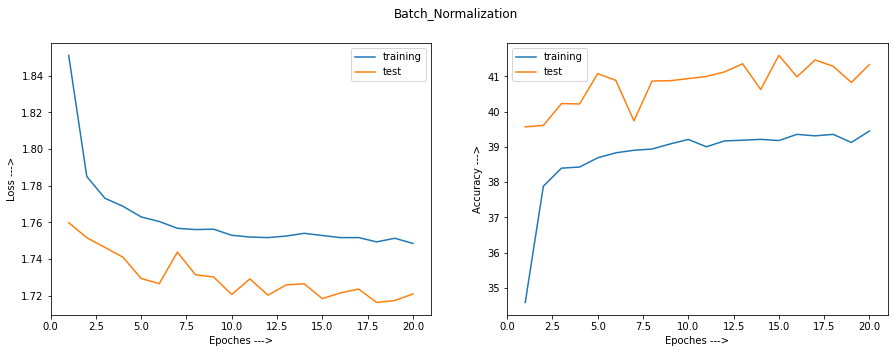

In [36]:
show_rlt(rlt_const, 'Batch_Normalization')

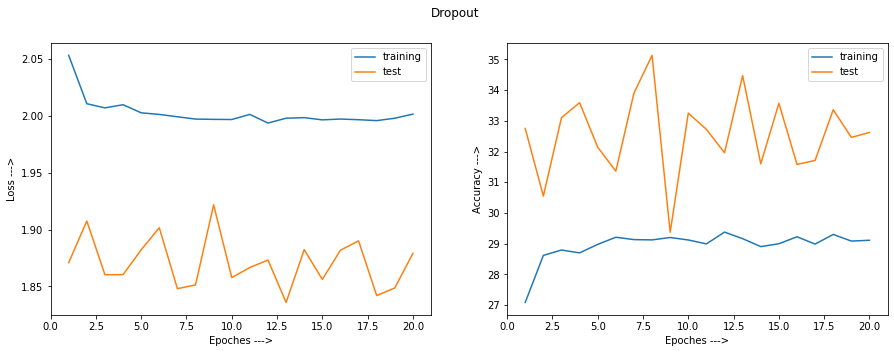

In [37]:
show_rlt(rlt_const2, 'Dropout')

결론 

case 1. lr이 0.01인 경우 -> Batch_Normalization에서는 좋다. Dropout에서는 학습이 제대로 되지 않는 모습. 이전 과제에서 lr을 잘못 설정하면 수렴하지 못하는 경우를 봤는데 아마 이 경우인 것으로 추측
case 2. lr이 0.005인 경우 ->  Batch_Normalization, Dropout에서 둘다 좋다. 
case 3. case 2에서 조금 늘려 lr이 0.006인 경우 ->  Batch_Normalization, Dropout에서 둘다 좋다. 
case 4. case 2에서 조금 줄여 lr이 0.004인 경우 ->  Batch_Normalization, Dropout에서 둘다 좋다. 
case 5. case 1에서 5배 늘려 0.05인 경우 -> Batch_Normalization의 경우 학습이 불안정하다고 생각됨. accuracy도 case 2,3,4에 비해 적을뿐더러 loss가 줄어가는 그래프도 덜 스무스함.

이 case들로 미루어 보았을 때 나의 경우에는, lr이 작을 때 더 좋은 성능을 보였기 때문에 lr을 작게 Hyperparameter 설정하는 것이 성능이 좋다.
그렇다면 lr이 작은 case 2,3,4 중에서 하나를 골라야함. (크게 차이는 없다고 생각하지만) case 4가 이 경우 가장 적합하고 좋은 성능을 보였다고 생각한다.
accuracy의 상승과 loss의 감소는 Batch_Normalization과 Dropout 이 두가지에서 다 좋았다. 그렇기 때문에 다른 잣대를 적용해야 했고, case 4의 경우가 Dropout에서 train data와 test data의 차이가 그나마 적었다.